In [1]:
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

In [3]:
print(tf.__version__)

2.6.0


In [4]:
tf.random.set_seed(42)
np.random.seed(42)

In [6]:
train_df = pd.read_csv('../data/train.csv', index_col=0)
val_df = pd.read_csv('../data/val.csv', index_col=0)
test_df = pd.read_csv('../data/test.csv', index_col=0)

print(train_df.shape, val_df.shape, test_df.shape)

(12285, 5) (3510, 5) (1756, 5)


# Chapter 13 

## 13.1 Creating windows of data
### 13.1.1 Exploring how deep learning models are trained for time series forecasting

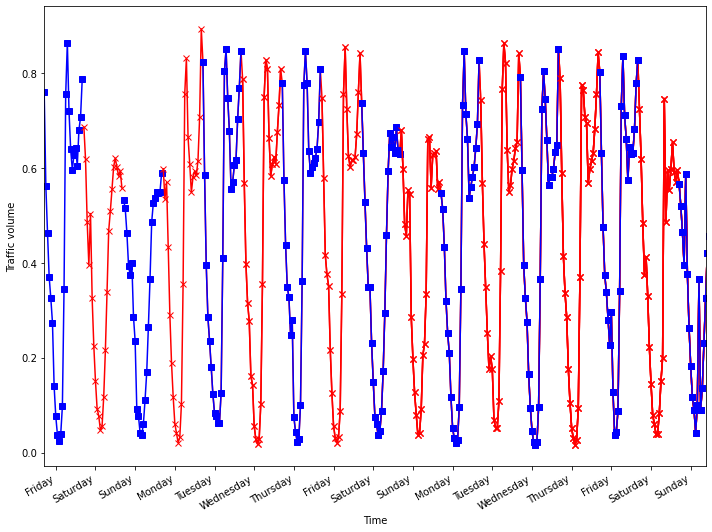

In [7]:
fig, ax = plt.subplots()

for n in range(0,17,2):
    start = 24*n
    stop = 24*(n+1)
    ax.plot(train_df.traffic_volume[start:stop], marker='s', color='blue', label='input')
    ax.plot(train_df.traffic_volume[stop:2*stop], marker='x', color='red', label='label')
ax.set_xlabel('Time')
ax.set_ylabel('Traffic volume')

plt.xticks(np.arange(7, 400, 24), ['Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.xlim(0, 400)

fig.autofmt_xdate()
plt.tight_layout()

# plt.savefig('figures/CH13_F01_peixeiro.png', dpi=300)

### 13.1.2 Implementing the `DataWindow` class 

In [8]:
class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='traffic_volume', max_subplots=3):
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

## 13.2 Applying baseline models
### 13.2.1 Single-step baseline model

In [9]:
single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['traffic_volume']) 
wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['traffic_volume'])

In [10]:
class Baseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        if self.label_index is None:
            return inputs
        
        elif isinstance(self.label_index, list):
            tensors = []
            for index in self.label_index:
                result = inputs[:, :, index]
                result = result[:, :, tf.newaxis]
                tensors.append(result)
            return tf.concat(tensors, axis=-1)
        
        result = inputs[:, :, self.label_index]
        return result[:,:,tf.newaxis]

In [11]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}

baseline_last = Baseline(label_index=column_indices['traffic_volume'])

baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

In [12]:
val_performance = {}
performance = {}

val_performance['Baseline - Last'] = baseline_last.evaluate(single_step_window.val)
performance['Baseline - Last'] = baseline_last.evaluate(single_step_window.test, verbose=0)

110/110 [==============================] - 1s 2ms/step - loss: 0.0133 - mean_absolute_error: 0.0831


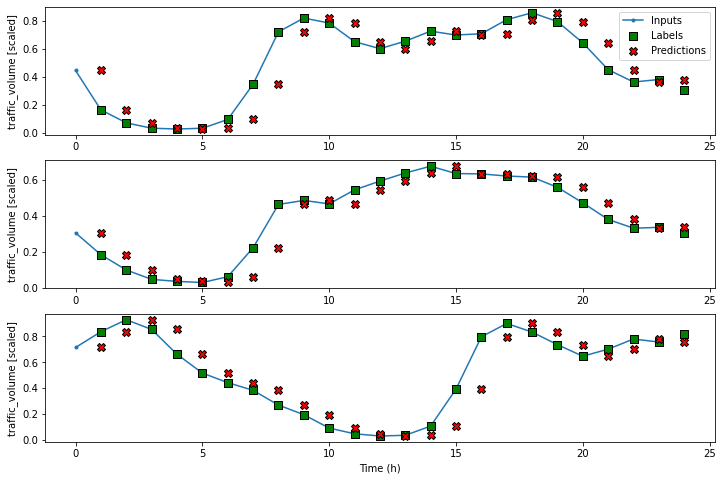

In [13]:
wide_window.plot(baseline_last)

plt.savefig('figures/CH13_F09_peixeiro.png', dpi=300)

In [14]:
print(performance['Baseline - Last'][1])

0.08128400146961212


### 13.2.2 Multi-step baseline models 

In [15]:
multi_window = DataWindow(input_width=24, label_width=24, shift=24, label_columns=['traffic_volume'])

#### Predicting the last known value 

In [16]:
class MultiStepLastBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        if self.label_index is None:
            return tf.tile(inputs[:, -1:, :], [1, 24, 1])
        return tf.tile(inputs[:, -1:, self.label_index:], [1, 24, 1])

In [17]:
ms_baseline_last = MultiStepLastBaseline(label_index=column_indices['traffic_volume'])

ms_baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

ms_val_performance = {}
ms_performance = {}

ms_val_performance['Baseline - Last'] = ms_baseline_last.evaluate(multi_window.val)
ms_performance['Baseline - Last'] = ms_baseline_last.evaluate(multi_window.test, verbose=0)

109/109 [==============================] - 1s 601us/step - loss: 0.1875 - mean_absolute_error: 0.3522


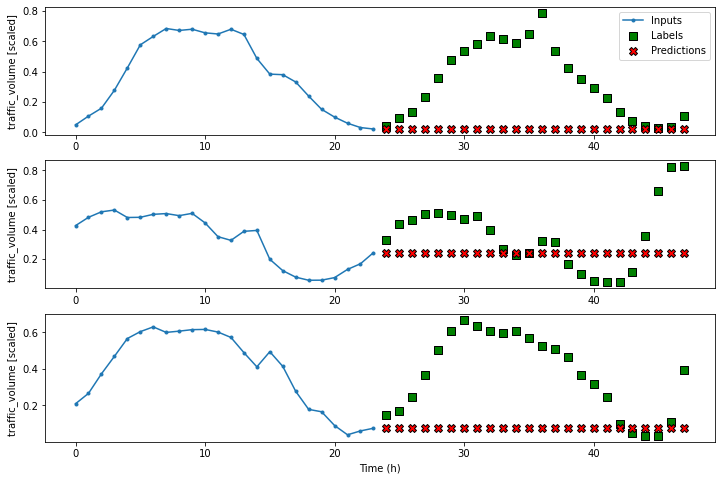

In [18]:
multi_window.plot(ms_baseline_last)

plt.savefig('figures/CH13_F10_peixeiro.png', dpi=300)

In [19]:
print(ms_performance['Baseline - Last'][1])

0.3472606837749481


#### Repeating the input sequence 

In [20]:
class RepeatBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        return inputs[:, :, self.label_index:]

In [21]:
ms_baseline_repeat = RepeatBaseline(label_index=column_indices['traffic_volume'])

ms_baseline_repeat.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

ms_val_performance['Baseline - Repeat'] = ms_baseline_repeat.evaluate(multi_window.val)
ms_performance['Baseline - Repeat'] = ms_baseline_repeat.evaluate(multi_window.test, verbose=0)

109/109 [==============================] - 0s 822us/step - loss: 0.2065 - mean_absolute_error: 0.3473


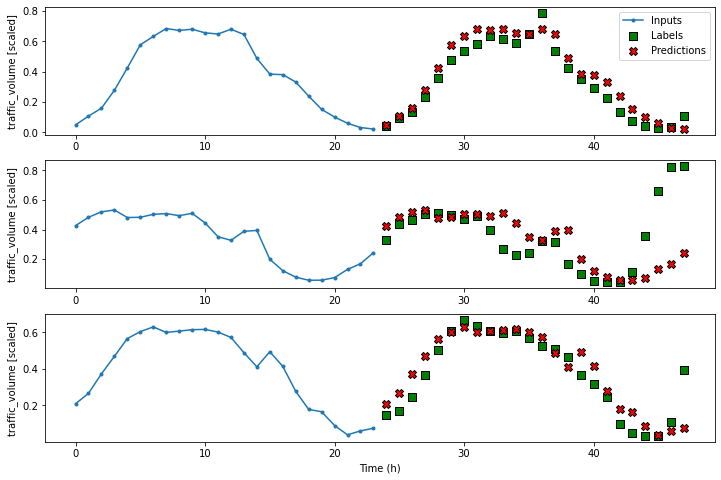

In [22]:
multi_window.plot(ms_baseline_repeat)

plt.savefig('figures/CH13_F11_peixeiro.png', dpi=300)

In [23]:
print(ms_performance['Baseline - Repeat'][1])

0.341277152299881


### 13.2.3 Multi-output baseline model 

In [24]:
mo_single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['temp','traffic_volume']) 
mo_wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['temp','traffic_volume'])

In [25]:
print(column_indices['traffic_volume'])
print(column_indices['temp'])

2
0


In [26]:
mo_baseline_last = Baseline(label_index=[0, 2])

mo_baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

mo_val_performance = {}
mo_performance = {}

mo_val_performance['Baseline - Last'] = mo_baseline_last.evaluate(mo_wide_window.val)
mo_performance['Baseline - Last'] = mo_baseline_last.evaluate(mo_wide_window.test, verbose=0)

109/109 [==============================] - 0s 1ms/step - loss: 0.0069 - mean_absolute_error: 0.0482


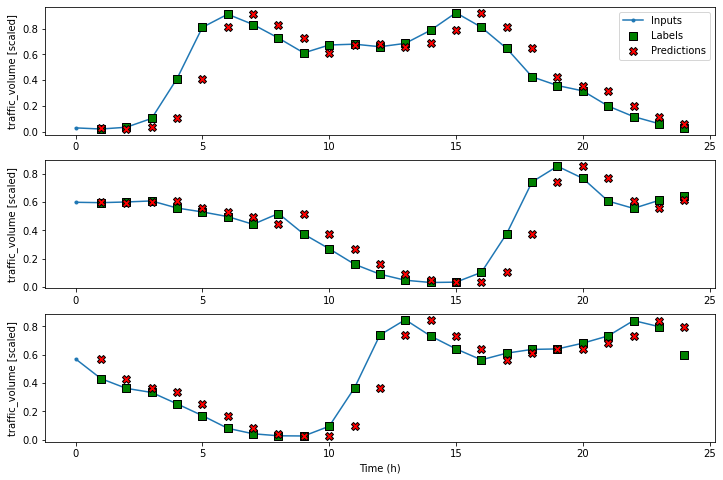

In [27]:
mo_wide_window.plot(mo_baseline_last)

plt.savefig('figures/CH13_F12_peixeiro.png', dpi=300)

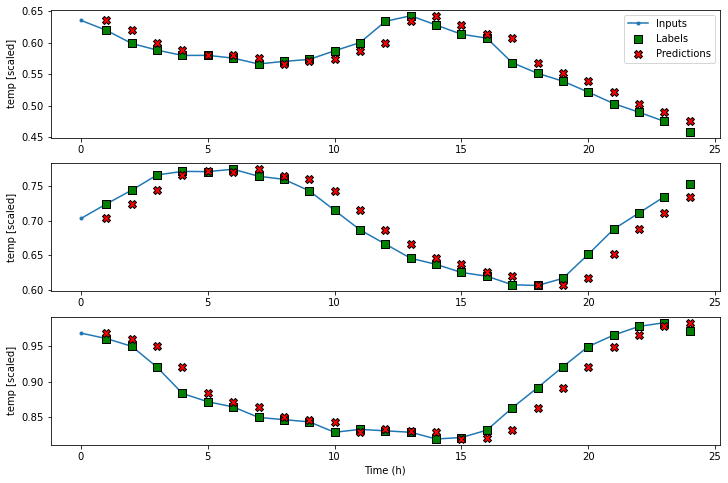

In [28]:
mo_wide_window.plot(model=mo_baseline_last, plot_col='temp')

plt.savefig('figures/CH13_F13_peixeiro.png', dpi=300)

In [29]:
print(mo_performance['Baseline - Last'][1])

0.04710667207837105


# Chapter 14 

## 14.1 Implementing a linear model
### 14.1.1 Building a single-step linear model

In [30]:
def compile_and_fit(model, window, patience=3, max_epochs=50):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')
    
    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])
    
    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])
    
    return history

In [31]:
linear = Sequential([
    Dense(units=1)
])

history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/50
384/384 [==============================] - 2s 2ms/step - loss: 0.3908 - mean_absolute_error: 0.5104 - val_loss: 0.1104 - val_mean_absolute_error: 0.2756
Epoch 2/50
384/384 [==============================] - 0s 830us/step - loss: 0.0948 - mean_absolute_error: 0.2537 - val_loss: 0.0669 - val_mean_absolute_error: 0.2108
Epoch 3/50
384/384 [==============================] - 0s 822us/step - loss: 0.0573 - mean_absolute_error: 0.1957 - val_loss: 0.0428 - val_mean_absolute_error: 0.1686
Epoch 4/50
384/384 [==============================] - 0s 822us/step - loss: 0.0372 - mean_absolute_error: 0.1571 - val_loss: 0.0304 - val_mean_absolute_error: 0.1422
Epoch 5/50
384/384 [==============================] - 0s 804us/step - loss: 0.0267 - mean_absolute_error: 0.1326 - val_loss: 0.0238 - val_mean_absolute_error: 0.1254
Epoch 6/50
384/384 [==============================] - 0s 820us/step - loss: 0.0209 - mean_absolute_error: 0.1162 - val_loss: 0.0195 - val_mean_absolute_error: 0.1125
Epoch 

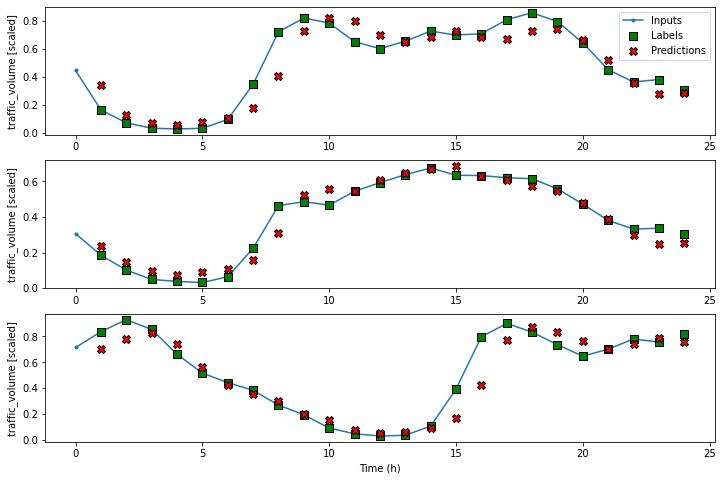

In [32]:
wide_window.plot(linear)

plt.savefig('figures/CH14_F02_peixeiro.png', dpi=300)

### 14.1.2 Building a mutli-step linear model 

In [33]:
ms_linear = Sequential([
    Dense(1, kernel_initializer=tf.initializers.zeros)
])

history = compile_and_fit(ms_linear, multi_window)

ms_val_performance['Linear'] = ms_linear.evaluate(multi_window.val)
ms_performance['Linear'] = ms_linear.evaluate(multi_window.test, verbose=0)

Epoch 1/50
383/383 [==============================] - 1s 2ms/step - loss: 0.0900 - mean_absolute_error: 0.2467 - val_loss: 0.0458 - val_mean_absolute_error: 0.1822: 0s - loss: 0.0939 - mean_absolute_error: 0.252
Epoch 2/50
383/383 [==============================] - 0s 832us/step - loss: 0.0298 - mean_absolute_error: 0.1369 - val_loss: 0.0261 - val_mean_absolute_error: 0.1253
Epoch 3/50
383/383 [==============================] - 0s 806us/step - loss: 0.0201 - mean_absolute_error: 0.1045 - val_loss: 0.0212 - val_mean_absolute_error: 0.1073
Epoch 4/50
383/383 [==============================] - 0s 801us/step - loss: 0.0177 - mean_absolute_error: 0.0955 - val_loss: 0.0196 - val_mean_absolute_error: 0.0999
Epoch 5/50
383/383 [==============================] - 0s 809us/step - loss: 0.0168 - mean_absolute_error: 0.0914 - val_loss: 0.0188 - val_mean_absolute_error: 0.0953
Epoch 6/50
383/383 [==============================] - 0s 801us/step - loss: 0.0164 - mean_absolute_error: 0.0887 - val_loss:

### 14.1.3 Implementing a multi-output linear model 

In [34]:
mo_linear = Sequential([
    Dense(units=2)
])

history = compile_and_fit(mo_linear, mo_single_step_window)

mo_val_performance['Linear'] = mo_linear.evaluate(mo_single_step_window.val)
mo_performance['Linear'] = mo_linear.evaluate(mo_single_step_window.test, verbose=0)

Epoch 1/50
384/384 [==============================] - 2s 990us/step - loss: 0.1049 - mean_absolute_error: 0.2502 - val_loss: 0.0579 - val_mean_absolute_error: 0.1833
Epoch 2/50
384/384 [==============================] - 0s 830us/step - loss: 0.0406 - mean_absolute_error: 0.1509 - val_loss: 0.0279 - val_mean_absolute_error: 0.1239
Epoch 3/50
384/384 [==============================] - 0s 838us/step - loss: 0.0201 - mean_absolute_error: 0.1065 - val_loss: 0.0152 - val_mean_absolute_error: 0.0926
Epoch 4/50
384/384 [==============================] - 0s 830us/step - loss: 0.0118 - mean_absolute_error: 0.0819 - val_loss: 0.0098 - val_mean_absolute_error: 0.0742
Epoch 5/50
384/384 [==============================] - 0s 833us/step - loss: 0.0083 - mean_absolute_error: 0.0672 - val_loss: 0.0073 - val_mean_absolute_error: 0.0620
Epoch 6/50
384/384 [==============================] - 0s 830us/step - loss: 0.0067 - mean_absolute_error: 0.0581 - val_loss: 0.0060 - val_mean_absolute_error: 0.0545
Epoc

## 14.2 Implementing a deep neural network
### 14.2.1 Implementing a deep neural network as a single-step model

In [35]:
dense = Sequential([
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/50
384/384 [==============================] - 2s 2ms/step - loss: 0.0218 - mean_absolute_error: 0.0885 - val_loss: 0.0048 - val_mean_absolute_error: 0.0517
Epoch 2/50
384/384 [==============================] - 0s 948us/step - loss: 0.0043 - mean_absolute_error: 0.0489 - val_loss: 0.0036 - val_mean_absolute_error: 0.0450
Epoch 3/50
384/384 [==============================] - 0s 971us/step - loss: 0.0038 - mean_absolute_error: 0.0452 - val_loss: 0.0030 - val_mean_absolute_error: 0.0407
Epoch 4/50
384/384 [==============================] - 0s 950us/step - loss: 0.0035 - mean_absolute_error: 0.0431 - val_loss: 0.0044 - val_mean_absolute_error: 0.0524
Epoch 5/50
384/384 [==============================] - 0s 943us/step - loss: 0.0034 - mean_absolute_error: 0.0422 - val_loss: 0.0031 - val_mean_absolute_error: 0.0417
Epoch 6/50
384/384 [==============================] - 0s 948us/step - loss: 0.0032 - mean_absolute_error: 0.0414 - val_loss: 0.0026 - val_mean_absolute_error: 0.0379
Epoch 

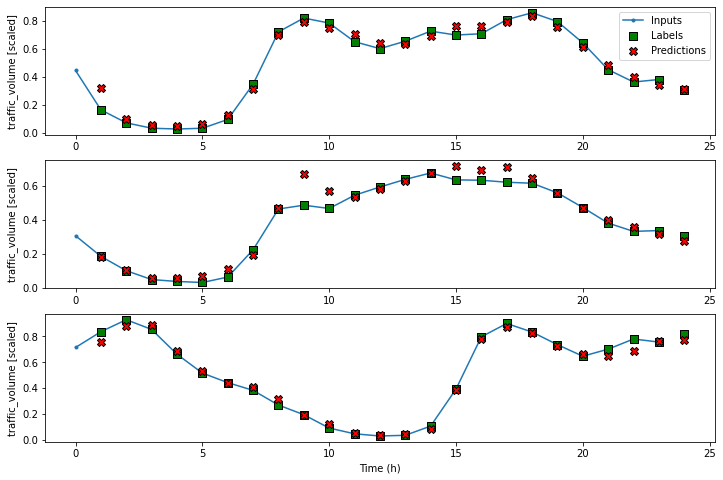

In [36]:
wide_window.plot(dense)

plt.savefig('figures/CH14_F06_peixeiro.png', dpi=300)

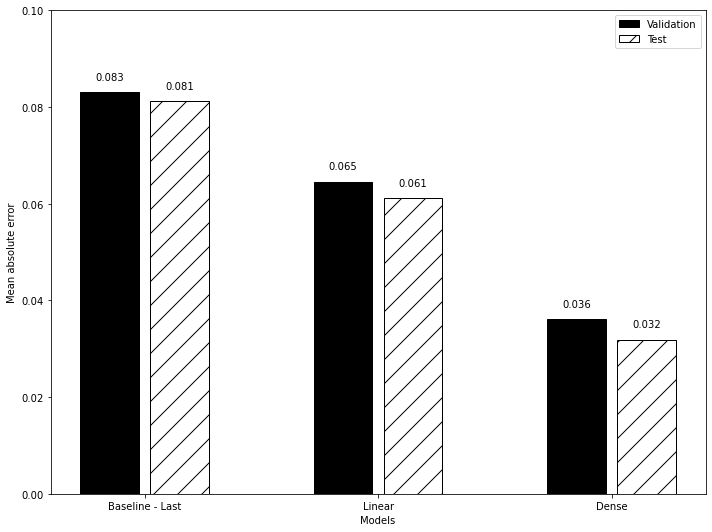

In [37]:
mae_val = [v[1] for v in val_performance.values()]
mae_test = [v[1] for v in performance.values()]

x = np.arange(len(performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.1)
plt.xticks(ticks=x, labels=performance.keys())
plt.legend(loc='best')
plt.tight_layout()

plt.savefig('figures/CH14_F07_peixeiro.png', dpi=300)

### 14.2.2 Implementing a deep neural network as a multi-step model 

In [38]:
ms_dense = Sequential([
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(ms_dense, multi_window)

ms_val_performance['Dense'] = ms_dense.evaluate(multi_window.val)
ms_performance['Dense'] = ms_dense.evaluate(multi_window.test, verbose=0)

Epoch 1/50
383/383 [==============================] - 1s 2ms/step - loss: 0.0298 - mean_absolute_error: 0.1097 - val_loss: 0.0162 - val_mean_absolute_error: 0.0819
Epoch 2/50
383/383 [==============================] - 1s 1ms/step - loss: 0.0138 - mean_absolute_error: 0.0779 - val_loss: 0.0158 - val_mean_absolute_error: 0.0788
Epoch 3/50
383/383 [==============================] - 1s 1ms/step - loss: 0.0133 - mean_absolute_error: 0.0770 - val_loss: 0.0152 - val_mean_absolute_error: 0.0829
Epoch 4/50
383/383 [==============================] - 1s 1ms/step - loss: 0.0132 - mean_absolute_error: 0.0766 - val_loss: 0.0150 - val_mean_absolute_error: 0.0843
Epoch 5/50
383/383 [==============================] - 1s 1ms/step - loss: 0.0130 - mean_absolute_error: 0.0760 - val_loss: 0.0150 - val_mean_absolute_error: 0.0772
Epoch 6/50
383/383 [==============================] - 1s 1ms/step - loss: 0.0130 - mean_absolute_error: 0.0760 - val_loss: 0.0149 - val_mean_absolute_error: 0.0769
Epoch 7/50
383/3

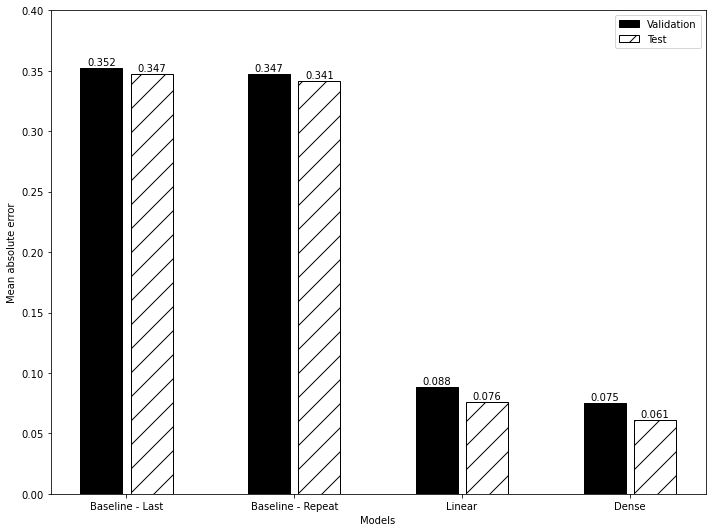

In [39]:
ms_mae_val = [v[1] for v in ms_val_performance.values()]
ms_mae_test = [v[1] for v in ms_performance.values()]

x = np.arange(len(ms_performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, ms_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, ms_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(ms_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(ms_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.4)
plt.xticks(ticks=x, labels=ms_performance.keys())
plt.legend(loc='best')
plt.tight_layout()

plt.savefig('figures/CH14_F08_peixeiro.png', dpi=300)

### 14.2.3 Implementing a deep neural network as a multi-output model 

In [40]:
mo_dense = Sequential([
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=2)
])

history = compile_and_fit(mo_dense, mo_single_step_window)

mo_val_performance['Dense'] = mo_dense.evaluate(mo_single_step_window.val)
mo_performance['Dense'] = mo_dense.evaluate(mo_single_step_window.test, verbose=0)

Epoch 1/50
384/384 [==============================] - 1s 2ms/step - loss: 0.0139 - mean_absolute_error: 0.0663 - val_loss: 0.0032 - val_mean_absolute_error: 0.0362
Epoch 2/50
384/384 [==============================] - 0s 974us/step - loss: 0.0032 - mean_absolute_error: 0.0355 - val_loss: 0.0027 - val_mean_absolute_error: 0.0334
Epoch 3/50
384/384 [==============================] - 0s 943us/step - loss: 0.0028 - mean_absolute_error: 0.0328 - val_loss: 0.0022 - val_mean_absolute_error: 0.0299
Epoch 4/50
384/384 [==============================] - 0s 958us/step - loss: 0.0024 - mean_absolute_error: 0.0307 - val_loss: 0.0021 - val_mean_absolute_error: 0.0299
Epoch 5/50
384/384 [==============================] - 0s 937us/step - loss: 0.0022 - mean_absolute_error: 0.0290 - val_loss: 0.0017 - val_mean_absolute_error: 0.0269
Epoch 6/50
384/384 [==============================] - 0s 940us/step - loss: 0.0021 - mean_absolute_error: 0.0279 - val_loss: 0.0017 - val_mean_absolute_error: 0.0261
Epoch 

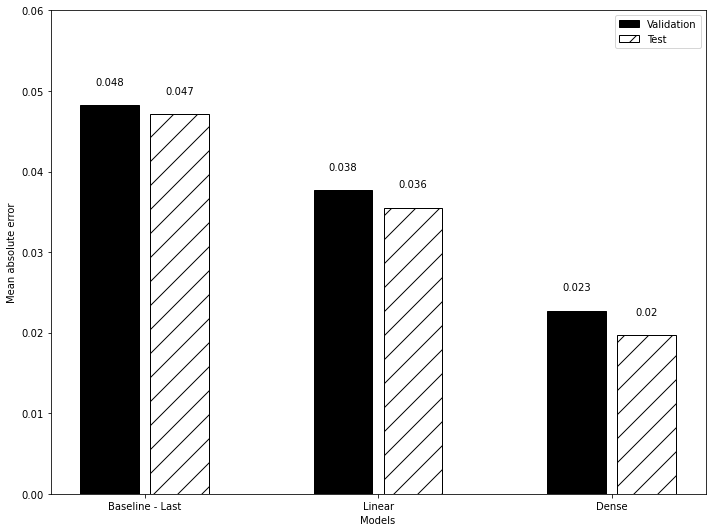

In [41]:
mo_mae_val = [v[1] for v in mo_val_performance.values()]
mo_mae_test = [v[1] for v in mo_performance.values()]

x = np.arange(len(mo_performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, mo_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mo_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mo_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mo_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.06)
plt.xticks(ticks=x, labels=mo_performance.keys())
plt.legend(loc='best')
plt.tight_layout()

plt.savefig('figures/CH14_F09_peixeiro.png', dpi=300)